## Eye State Classification from EEG


### Introduction


### Data Prep



In [1]:
# setting the random seed for reproducibility
import random
seed=42
random.seed(seed)

In [2]:
# import libraries 
import itertools
import requests
import os.path
import numpy as np
import pandas as pd
from scipy.io import arff
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

### Load the Data

In [3]:
# check if data file exists locally
if not os.path.isfile('EEG Eye State.arff'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff'
    r = requests.get(url, allow_redirects=True)
    open('EEG Eye State.arff', 'wb').write(r.content)

# read data from local csv file
#df = pd.read_csv("EEGEyeState.csv", header=None)

# read data from local arff file
data = arff.loadarff('EEG Eye State.arff')
df = pd.DataFrame(data[0])

In [4]:
# reject NaN entries
df.dropna()

# insert columns names
df.columns = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']

# remove outliers
df1 = df[df.loc[:, df.columns != 'eyeDetection'].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

# define data samples
X = df1.iloc[0:, 0:14].values

# standardize data
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_short = min_max_scaler.fit_transform(X)

# define target
y_short = df1.iloc[0:,14].values.astype(int)

unique, counts = np.unique(y_short, return_counts=True)
print(dict(zip(unique, counts)))

print(df.shape)
print(X_short,X_short.shape,'\n\n',
      y_short,y_short.shape)

{0: 8172, 1: 6720}
(14980, 15)
[[0.43315296 0.42978053 0.53914831 ... 0.44283486 0.52808589 0.51187141]
 [0.41794246 0.41065428 0.56628488 ... 0.43715177 0.51965054 0.48535451]
 [0.4280718  0.41915944 0.57527166 ... 0.4514152  0.50842166 0.49930648]
 ...
 [0.26227399 0.35319255 0.289163   ... 0.3171384  0.4072796  0.36402948]
 [0.2859641  0.35742439 0.31624082 ... 0.36856474 0.41993263 0.3947075 ]
 [0.29609344 0.38086545 0.36745962 ... 0.4085692  0.4241503  0.3947075 ]] (14892, 14) 

 [0 0 0 ... 1 1 1] (14892,)


### Model



In [5]:
# full dataset parameters

# define model parameters
samples = X_short.shape[0]  # how many trials of eeg data
n_features = X_short.shape[1]  # how many channels of eeg in each sample
time_steps = 1 # how many ms was each sample run for

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=seed)
sss.get_n_splits(X_short, y_short)

# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X_short, y_short):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_short[train_index], X_short[test_index]
    y_train, y_test = y_short[train_index], y_short[test_index]
    
X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], time_steps)

X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], time_steps)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, TerminateOnNaN

model = Sequential()
model.add(Bidirectional(GRU(28, return_sequences=True, 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               input_shape=(time_steps, n_features))))
model.add(Bidirectional(GRU(28, input_shape=(time_steps, n_features), 
               recurrent_regularizer=l1_l2(0.0001, 0.0001),
               return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(28, input_shape=(time_steps, n_features),
              recurrent_regularizer=l1_l2(0.0001, 0.0001))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto')

terminate_NaN = TerminateOnNaN()

history = model.fit(X_train, y_train, validation_split=0.25, 
                    batch_size=28, epochs=1000, verbose=1, 
                    callbacks=[early_stop, terminate_NaN])

Train on 8934 samples, validate on 2979 samples
Epoch 1/1000
8934/8934 [==============================] - 12s 1ms/step - loss: 0.6909 - acc: 0.5794 - val_loss: 0.6556 - val_acc: 0.6029
Epoch 2/1000
8934/8934 [==============================] - 5s 527us/step - loss: 0.6526 - acc: 0.6183 - val_loss: 0.6437 - val_acc: 0.6311
Epoch 3/1000
8934/8934 [==============================] - 5s 521us/step - loss: 0.6366 - acc: 0.6316 - val_loss: 0.6841 - val_acc: 0.5378
Epoch 4/1000
8934/8934 [==============================] - 5s 521us/step - loss: 0.6159 - acc: 0.6570 - val_loss: 0.6910 - val_acc: 0.5935
Epoch 5/1000
8934/8934 [==============================] - 5s 525us/step - loss: 0.5869 - acc: 0.6857 - val_loss: 0.7399 - val_acc: 0.6032
Epoch 6/1000
8934/8934 [==============================] - 5s 526us/step - loss: 0.5549 - acc: 0.7131 - val_loss: 0.5338 - val_acc: 0.7331
Epoch 7/1000
8934/8934 [==============================] - 5s 518us/step - loss: 0.5258 - acc: 0.7343 - val_loss: 0.5243 - val

Epoch 118/1000
8934/8934 [==============================] - 6s 697us/step - loss: 0.2341 - acc: 0.9005 - val_loss: 0.2481 - val_acc: 0.8865
Epoch 119/1000
8934/8934 [==============================] - 6s 710us/step - loss: 0.2337 - acc: 0.9018 - val_loss: 0.2063 - val_acc: 0.9188
Epoch 120/1000
8934/8934 [==============================] - 6s 695us/step - loss: 0.2309 - acc: 0.9024 - val_loss: 0.2018 - val_acc: 0.9168
Epoch 121/1000
8934/8934 [==============================] - 6s 691us/step - loss: 0.2335 - acc: 0.9030 - val_loss: 0.2268 - val_acc: 0.9050
Epoch 122/1000
8934/8934 [==============================] - 6s 704us/step - loss: 0.2282 - acc: 0.9062 - val_loss: 0.2424 - val_acc: 0.8973
Epoch 123/1000
8934/8934 [==============================] - 6s 700us/step - loss: 0.2283 - acc: 0.9040 - val_loss: 0.2242 - val_acc: 0.9070
Epoch 124/1000
8934/8934 [==============================] - 6s 695us/step - loss: 0.2264 - acc: 0.9041 - val_loss: 0.2105 - val_acc: 0.9124
Epoch 125/1000
8934/

8934/8934 [==============================] - 6s 708us/step - loss: 0.1589 - acc: 0.9355 - val_loss: 0.1518 - val_acc: 0.9426
Epoch 235/1000
8934/8934 [==============================] - 6s 711us/step - loss: 0.1591 - acc: 0.9366 - val_loss: 0.1555 - val_acc: 0.9419
Epoch 236/1000
8934/8934 [==============================] - 6s 688us/step - loss: 0.1696 - acc: 0.9309 - val_loss: 0.1467 - val_acc: 0.9416
Epoch 237/1000
8934/8934 [==============================] - 6s 710us/step - loss: 0.1594 - acc: 0.9380 - val_loss: 0.1351 - val_acc: 0.9456
Epoch 238/1000
8934/8934 [==============================] - 6s 706us/step - loss: 0.1622 - acc: 0.9355 - val_loss: 0.1585 - val_acc: 0.9355
Epoch 239/1000
8934/8934 [==============================] - 6s 696us/step - loss: 0.1665 - acc: 0.9324 - val_loss: 0.1516 - val_acc: 0.9379
Epoch 240/1000
8934/8934 [==============================] - 6s 697us/step - loss: 0.1625 - acc: 0.9355 - val_loss: 0.1510 - val_acc: 0.9409
Epoch 241/1000
8934/8934 [=========

8934/8934 [==============================] - 6s 628us/step - loss: 0.1328 - acc: 0.9477 - val_loss: 0.1312 - val_acc: 0.9449
Epoch 351/1000
8934/8934 [==============================] - 6s 632us/step - loss: 0.1294 - acc: 0.9494 - val_loss: 0.1178 - val_acc: 0.9564
Epoch 352/1000
8934/8934 [==============================] - 6s 617us/step - loss: 0.1268 - acc: 0.9509 - val_loss: 0.1302 - val_acc: 0.9443
Epoch 353/1000
8934/8934 [==============================] - 6s 626us/step - loss: 0.1363 - acc: 0.9491 - val_loss: 0.1212 - val_acc: 0.9540
Epoch 354/1000
8934/8934 [==============================] - 6s 628us/step - loss: 0.1321 - acc: 0.9476 - val_loss: 0.1152 - val_acc: 0.9540
Epoch 355/1000
8934/8934 [==============================] - 6s 618us/step - loss: 0.1339 - acc: 0.9486 - val_loss: 0.1274 - val_acc: 0.9520
Epoch 356/1000
8934/8934 [==============================] - 5s 614us/step - loss: 0.1328 - acc: 0.9491 - val_loss: 0.1130 - val_acc: 0.9547
Epoch 357/1000
8934/8934 [=========

8934/8934 [==============================] - 5s 538us/step - loss: 0.1080 - acc: 0.9572 - val_loss: 0.1123 - val_acc: 0.9574
Epoch 467/1000
8934/8934 [==============================] - 5s 540us/step - loss: 0.1160 - acc: 0.9539 - val_loss: 0.1207 - val_acc: 0.9520
Epoch 468/1000
8934/8934 [==============================] - 5s 548us/step - loss: 0.1092 - acc: 0.9572 - val_loss: 0.0993 - val_acc: 0.9624
Epoch 469/1000
8934/8934 [==============================] - 5s 547us/step - loss: 0.0986 - acc: 0.9606 - val_loss: 0.1064 - val_acc: 0.9617
Epoch 470/1000
8934/8934 [==============================] - 5s 550us/step - loss: 0.1052 - acc: 0.9596 - val_loss: 0.1140 - val_acc: 0.9577
Epoch 471/1000
8934/8934 [==============================] - 5s 548us/step - loss: 0.1124 - acc: 0.9569 - val_loss: 0.1184 - val_acc: 0.9543
Epoch 472/1000
8934/8934 [==============================] - 5s 556us/step - loss: 0.1017 - acc: 0.9614 - val_loss: 0.1161 - val_acc: 0.9574
Epoch 473/1000
8934/8934 [=========

In [8]:
score = model.evaluate(X_test, y_test, batch_size=28)
score

2979/2979 [==============================] - 0s 115us/step


[0.10496525597621346, 0.9566968791874594]

In [9]:
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 95.67%


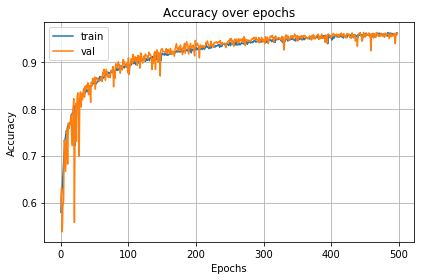

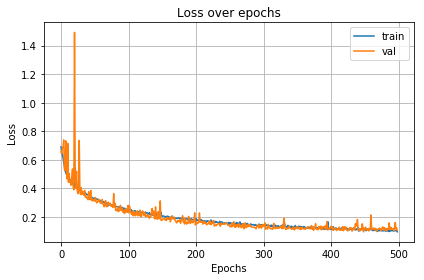

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.grid(True, which='both', axis='both')

# plt.minorticks_on()
plt.tight_layout()

plt.legend()
plt.show()

plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.legend()
plt.show()

# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [13]:
from keras.models import load_model

model.save('eeg_eye_state_model_bgru.h5')  # creates a HDF5 file 'my_model.h5'

# model = load_model('eeg_eye_state_model_bgru.h5')


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = model.predict_classes(X_test)
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.952
Recall: 0.952
F1: 0.952


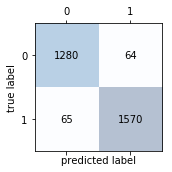

In [15]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
#print(confmat)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

ROC AUC: 0.956
Accuracy: 0.957


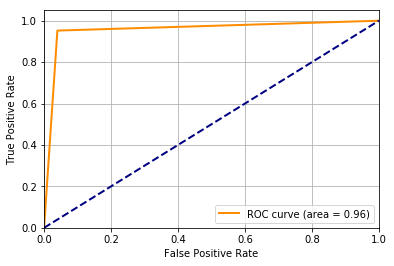

In [16]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2

plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

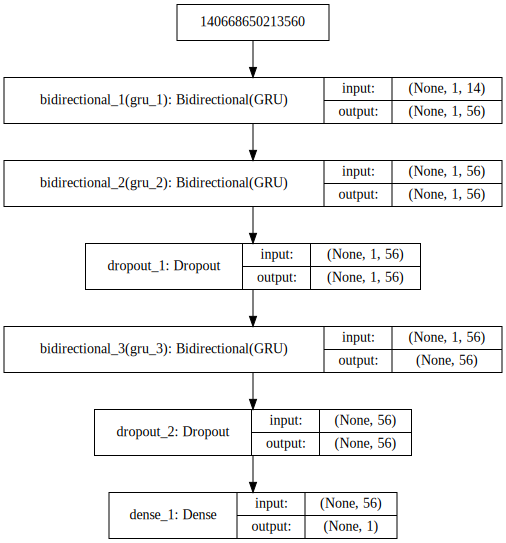

In [17]:
from keras.utils import plot_model
# plot_model(model, to_file='model.png')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))


In [18]:
from sklearn.metrics import classification_report
target_names = ['eye opened', 'eye closed']
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

              precision    recall  f1-score   support

  eye opened      0.961     0.960     0.961      1635
  eye closed      0.952     0.952     0.952      1344

   micro avg      0.957     0.957     0.957      2979
   macro avg      0.956     0.956     0.956      2979
weighted avg      0.957     0.957     0.957      2979



Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.93')

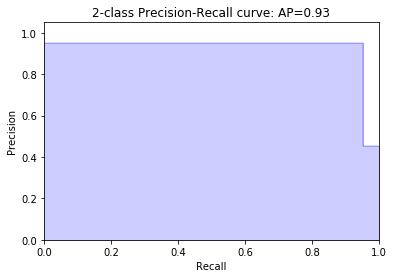

In [19]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 56)             7224      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 56)             14280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 56)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 56)                14280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 57        
Total params: 35,841
Trainable params: 35,841
Non-trainable params: 0
_________________________________________________________________
